In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['path_to_data'] = data_path+"ids/data/"
config['path_to_data3'] = data_path+f"ids/data03/"
config['path_to_data7'] = data_path+f"ids/data07/"

config['path_to_outdata'] = data_path+"ids/data/"

config['path_to_figures'] = data_path+"ids/figures/"

# experiment with cameras pararell at different rings
config['date1'] = "2024-05-02"
config['date2'] = "2024-05-20"


config['conversion'] = {"XX":1.67e-3,
                        "03":5.3e-3,
                        "07":5.3e-3,
                       }


In [4]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

In [5]:
mltiU = __load_mlti(config['date1'], config['date2'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

mltiZ = __load_mlti(config['date1'], config['date2'], "Z", archive_path)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

mltiV = __load_mlti(config['date1'], config['date2'], "V", archive_path)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)


In [6]:
def __load_beam_wander_data(tbeg, tend, path_to_data):

    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

    df = DataFrame()
    for dat in date_range(t1, t2):

        # print(str(dat)[:10])

        file = f"{str(dat)[:10].replace('-','')}.pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    # remove NaN from time column
    df.dropna(subset=['time'], inplace=True)

    # reset the index column
    df.reset_index(inplace=True, drop=True)

    # add column for relative time in seconds
    df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

    return df

In [7]:
df = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'])

In [8]:
df3 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data3'])

In [9]:
df7 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data7'])

### Remove MLTI times

In [10]:
def __pre_process(df0, mlti_t1, mlti_t2, conversion_factor):

    from functions.reduce import __reduce

    # local time to utc (! correct only in winter)
    df0['time_utc'] = [UTCDateTime(tl)-3600 for tl in df0.time]

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0[k] *= conversion_factor

    # turn times with MLTI to NaN
    df0 = __mlti_intervals_to_NaN(df0, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
    df0 = __mlti_intervals_to_NaN(df0, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 50]


    df0['x_um_rel'] = __reduce(df0.x, 10) * 1e3
    df0['y_um_rel'] = __reduce(df0.y, 10) * 1e3

    df0['x_um_sig'] = __reduce(df0.x_sig, 10) * 1e3
    df0['y_um_sig'] = __reduce(df0.y_sig, 10) * 1e3

    df0.reset_index(inplace=True)

    return df0

In [11]:
df = __pre_process(df, mltiU_t1, mltiU_t2, config['conversion']["XX"])

df7 = __pre_process(df7, mltiV_t1, mltiV_t2, config['conversion']["07"])

df3 = __pre_process(df3, mltiZ_t1, mltiZ_t2, config['conversion']["03"])


### Plotting

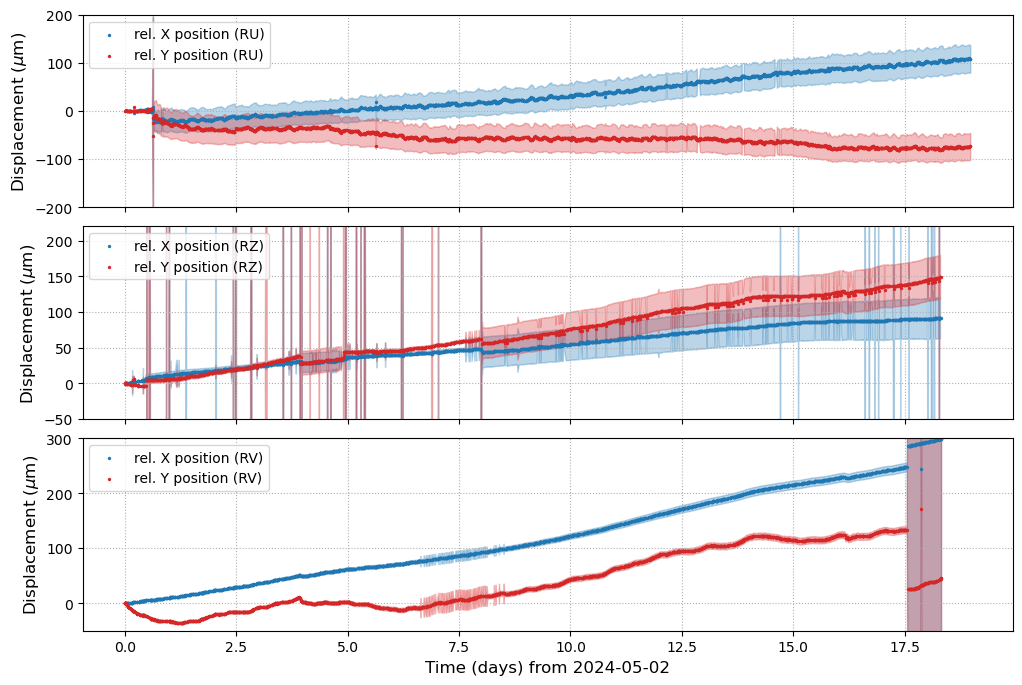

In [12]:
def __makeplot_overview():

    Nrow, Ncol = 3, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    for n, (_df, ring) in enumerate(zip([df, df3, df7], ["RU", "RZ", "RV"])):

        ax[n].fill_between(_df.time_sec*tscale, _df.x_um_rel-_df.x_um_sig/2, _df.x_um_rel+_df.x_um_sig/2,
                           color="tab:blue", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.x_um_rel, s=size, zorder=2, color="tab:blue", label=f"rel. X position ({ring})")

        ax[n].fill_between(_df.time_sec*tscale, _df.y_um_rel-_df.y_um_sig/2, _df.y_um_rel+_df.y_um_sig/2,
                           color="tab:red", alpha=0.3, interpolate=False
                          )
        ax[n].scatter(_df.time_sec*tscale, _df.y_um_rel, s=size, zorder=2, color="tab:red", label=f"rel. Y position ({ring})")
        # ax[n].set_ylim(1.58, 1.69)
        ax[n].set_ylabel(f"Displacement ($\mu$m)", fontsize=font)

        ax[n].legend(loc=2)

    ax[0].set_ylim(-200, 200)
    ax[1].set_ylim(-50, 220)
    ax[2].set_ylim(-50, 300)

    # ax[2].fill_between(_df.time_sec*tscale, _df.amp-_df.amp_var, _df.amp+_df.amp_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    # ax[2].scatter(_df.time_sec*tscale, _df.amp, s=size, zorder=2, color="k")
    # ax[2].set_ylim(110, 130)
    # ax[2].set_ylabel("Intensity")

#     ax[3].fill_between(df.time_sec*tscale, df.x_sig-df.x_sig_var, df.x_sig+df.x_sig_var,
#                        color="grey", alpha=0.7, interpolate=False
#                       )
#     ax[3].scatter(df.time_sec*tscale, df.x_sig, s=size, zorder=2, color="k")
#     ax[3].set_ylim(511, 518)
#     ax[3].set_ylabel("Sigma X")

#     ax[4].fill_between(df.time_sec*tscale, df.y_sig-df.y_sig_var, df.y_sig+df.y_sig_var,
#                        color="grey", alpha=0.7, interpolate=False
#                       )
#     ax[4].scatter(df.time_sec*tscale, df.y_sig, s=size, zorder=2, color="k")
#     ax[4].set_ylim(480, 495)
#     ax[4].set_ylabel("Sigma Y")

#     ax[5].fill_between(df.time_sec*tscale, df.theta-df.theta_var, df.theta+df.theta_var,
#                        color="grey", alpha=0.7, interpolate=False
#                       )
#     ax[5].scatter(df.time_sec*tscale, df.theta, s=size, zorder=2, color="k")
#     ax[5].set_ylim(0.4, 0.55)
#     ax[5].set_ylabel("Theta")

#     ax[6].fill_between(df.time_sec*tscale, df.offset-df.offset_var, df.offset+df.offset_var,
#                        color="grey", alpha=0.7, interpolate=False
#                       )
#     ax[6].scatter(df.time_sec*tscale, df.offset, s=size, zorder=2, color="k")
#     ax[6].set_ylim(8.5, 11.5)
#     ax[6].set_ylabel("Offset")

    ax[Nrow-1].set_xlabel(f"Time (days) from {config['date1']}", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot_overview();

fig.savefig(config['path_to_figures']+f"BeamWander_overview_{config['date1']}_{config['date2']}.png", format="png", dpi=150, bbox_inches='tight')
